In [22]:
import numpy as np
import jax.numpy as jnp
import jax

from functools import partial 

import matplotlib.pyplot as plt

# from water_balance import run_wbm
# from water_balance_jax import wbm_jax

### JAX test

In [18]:
from jax import random

In [21]:
learning_rate = 0.1
def sgd(gradients, state):
    return -learning_rate * gradients, state

In [22]:
def quadratic_task(w, y, theta, opt_fn, opt_state, steps=100):
    @jax.jit
    def f(theta):
        product = jax.vmap(jnp.matmul)(w, theta)
        return jnp.mean(jnp.sum((product - y) ** 2, axis=1))

    losses = []
    for _ in range(steps):
        loss, grads = jax.value_and_grad(f)(theta)
        updates, opt_state = opt_fn(grads, opt_state)
        theta += updates
        losses.append(loss)

    return jnp.stack(losses), theta, opt_state

In [23]:
batch_size = 128
rng = random.PRNGKey(0)
keys = random.split(rng, 3)
w = random.normal(keys[0], (batch_size, 10, 10))
y = random.normal(keys[1], (batch_size, 10))
theta = random.normal(keys[2], (batch_size, 10))

In [24]:
losses, *_ = quadratic_task(w, y, theta, opt_fn=sgd, opt_state=None)

In [27]:
y.shape

(128, 10)

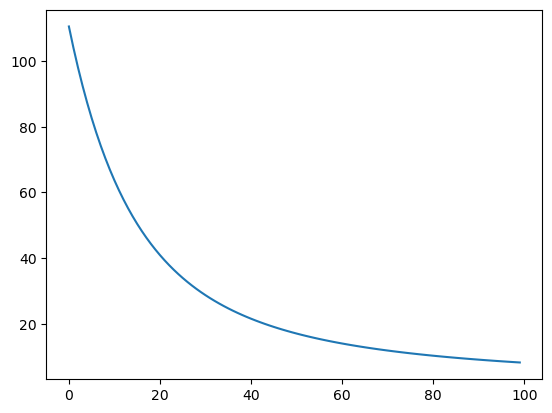

In [25]:
plt.plot(losses)

### JAX gradient descent test

In [2]:
# Simulate test data
test_in = np.load('/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/WBM/precalibration/centralUS/SMAP/inputs.npz')
test_out = np.load('/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/WBM/precalibration/centralUS/SMAP/SMAP_validation.npy')

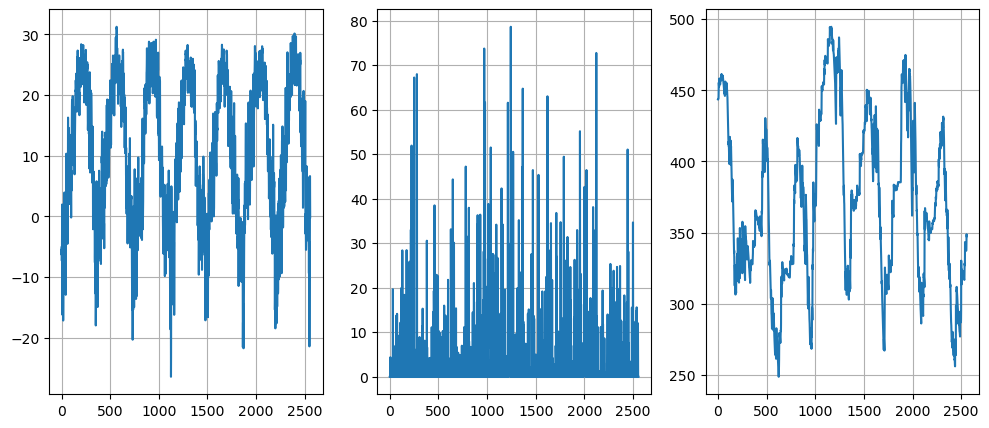

In [3]:
# Select random grid point
ix = 100
iy = 40

fig, axs = plt.subplots(1,3, figsize=(12,5))
axs[0].plot(test_in['tas'][ix,iy,:])
axs[0].grid()

axs[1].plot(test_in['prcp'][ix,iy,:])
axs[1].grid()

# Smap
axs[2].plot(test_out[ix,iy,:])
axs[2].grid()

plt.show()

In [110]:
@jax.jit
def update_state(state, forcing, params):
    """
    Stateless update function for WBM soil moisture simulation.
    """

    # Retrieve previous iteration values
    Ws_prev, Wi, Sp = state

    # Retrieve parameter values
    wiltingp, alpha, betaHBV, Wcap, phi = params

    # Retrieve forcing
    tas, prcp, lai, Kpet, doy = forcing

    # PET function
    def calculate_potential_evapotranspiration(tas, doy, phi):
        """
        Inputs:
         - tas: daily mean temperature [C]
         - N:   day of year
         - phi: latitude [deg]
        Outputs:
         - daily potential evapotranspiration calculated via the Hamon method [mm]
        Notes: (e.g.) http://data.snap.uaf.edu/data/Base/AK_2km/PET/Hamon_PET_equations.pdf
        """

        # Calculate solar declination (delta)
        delta = -23.44 * jnp.cos(jnp.radians((360 / 365) * (doy + 10)))

        # Calculate fractional day length (Lambda)
        pi = 3.14159265359
        Lambda = (1 / pi) * jnp.arccos(
            -jnp.tan(jnp.radians(phi)) * jnp.tan(jnp.radians(delta))
        )

        # Calculate saturation vapor pressure
        tas_gt_zero = tas > 0
        Psat = (tas_gt_zero * (0.61078 * jnp.exp((17.26939 * tas) / (tas + 237.3)))) + (
            ((1 - tas_gt_zero)) * (0.61078 * jnp.exp((21.87456 * tas) / (tas + 265.5)))
        )

        # Calculate saturation vapor density (rho_sat)
        rho_sat = (2.167 * Psat) / (tas + 273.15)

        # Calculate potential evapotranspiration (PET)
        PET = 330.2 * Lambda * rho_sat

        return PET

    ######################################
    # Begin simulation
    ######################################

    ################
    # Snowfall
    ################
    # Precipitation is assumed to be entirely snow/rain
    # if temperature is below/above threshold (Ts)
    is_snowfall = tas < -1

    Ps = (is_snowfall * prcp) + ((1 - is_snowfall) * 0.0)
    Pa = (is_snowfall * 0.0) + ((1 - is_snowfall) * prcp)

    Sp = Sp + Ps

    ################
    # Snowmelt
    ################
    # Snowmelt is assumed to occur if temperature
    # is above a threshold (Tm), but is limited to
    # the volume of the snowpack
    is_snowmelt = tas > 1
    Ms = is_snowmelt * (2.63 + 2.55 * tas + 0.0912 * tas * Pa) + (
        (1 - is_snowmelt) * 0.0
    )

    snowmelt_gt_snowpack = Ms > Sp
    Ms = (snowmelt_gt_snowpack * Sp) + ((1 - snowmelt_gt_snowpack) * Ms)
    Sp = (snowmelt_gt_snowpack * 0.0) + ((1 - snowmelt_gt_snowpack) * (Sp - Ms))

    #########################
    # Canopy & throughfall
    #########################
    # Maximum canopy storage scales with LAI
    Wi_max = 0.25 * lai

    # Open water evaporation rate assumed to be PET
    Eow = calculate_potential_evapotranspiration(tas, doy, phi)
    # Canopy evaporation
    Ec = Eow * ((Wi / Wi_max) ** 0.6666667)

    # Throughfall is rainfall minus (canopy storage plus canopy evaporation)
    # Throughfall if zero if all rainfall goes to canopy
    canopy_full = Wi_max < Wi + Pa - Ec
    Pt = (canopy_full * (Pa - Ec - (Wi_max - Wi))) + ((1 - canopy_full) * 0.0)

    # Update canopy storage
    canopy_space = Wi + (Pa - Pt) - Ec <= Wi_max
    canopy_leftover = Wi + (Pa - Pt) - Ec > 0.0

    Wi = (
        ((canopy_space * canopy_leftover) * (Wi + (Pa - Pt) - Ec))
        + ((canopy_space * (1 - canopy_leftover)) * 0.0)
        + ((1 - canopy_space) * Wi_max)
    )

    ########################
    # Evapotranspiration
    ########################
    # Potential ET scales with (annual) coefficient
    PET = Kpet * calculate_potential_evapotranspiration(tas, doy, phi)

    # Calculate actual evapotranspiration
    # Actual ET is limited by water availability (throughfall + snowmelt)
    # otherwise the difference is scaled by drying function
    avail_water = (Pt + Ms) >= PET
    AET = (avail_water * PET) + (
        (1 - avail_water)
        * ((1 - jnp.exp(-alpha * Ws_prev / Wcap)) / (1 - jnp.exp(-alpha)))
        * ((PET - Pt - Ms))
    )

    ################
    # Runoff
    ################
    # HBV direct groundwater recharge (can also be thought of as runoff)
    # scales nonlinearly with saturation in the active zone
    # Direct groundwater recharge (HBV)
    Id = (Pt + Ms) * (Ws_prev / Wcap) ** betaHBV

    ################
    # Soil moisture
    ################
    # Soil surplus is the leftover water after saturating soils
    # It gets partitioned to more runoff and groundwater recharge
    soil_full = Wcap < Ws_prev + (Pt + Ms - Id) - AET
    S = (soil_full * (Ws_prev + (Pt + Ms - Id) - AET - Wcap)) + ((1 - soil_full) * 0.0)

    # Update soil moisture
    Ws_new = Ws_prev + (Pt + Ms - Id) - AET - S

    # Soil moisture must be positive
    Ws_new = jnp.maximum(Ws_new, 0.0)

    # Soil moisture out (+ wilting point)
    Ws_out = Ws_prev + wiltingp

    return (Ws_new, Wi, Sp), Ws_out

@jax.jit
def wbm_jax(
    tas,
    prcp, 
    Ws_init,
    Wi_init,
    Sp_init,
    clayfrac,
    sandfrac,
    siltfrac,
    lai,
    phi,
    doy,
    params,
):
    """
    MAIN SOIL MOISTURE SIMULATION CODE
    """

    # Read parameters (must be correct order!)
    awCap_claycoef, awCap_sandcoef, awCap_siltcoef, \
        wiltingp_claycoef, wiltingp_sandcoef, wiltingp_siltcoef, \
        alpha_claycoef, alpha_sandcoef, alpha_siltcoef, \
        betaHBV_claycoef, betaHBV_sandcoef, betaHBV_siltcoef, \
        Kmin_claycoef, Kmin_sandcoef, Kmin_siltcoef, \
        Kmax_claycoef, Kmax_sandcoef, Kmax_siltcoef, \
        Klai_claycoef, Klai_sandcoef, Klai_siltcoef = params
    
    # Construct gridpoint parameters
    awCap = jnp.exp(awCap_claycoef) * clayfrac + jnp.exp(awCap_sandcoef) * sandfrac + jnp.exp(awCap_siltcoef) * siltfrac
    wiltingp = jnp.exp(wiltingp_claycoef) * clayfrac + jnp.exp(wiltingp_sandcoef) * sandfrac + jnp.exp(wiltingp_siltcoef) * siltfrac
    alpha = 1. + jnp.exp(alpha_claycoef) * clayfrac + jnp.exp(alpha_sandcoef) * sandfrac + jnp.exp(alpha_siltcoef) * siltfrac
    betaHBV = 1. + jnp.exp(betaHBV_claycoef) * clayfrac + jnp.exp(betaHBV_sandcoef) * sandfrac + jnp.exp(betaHBV_siltcoef) * siltfrac
    Kmin = jnp.exp(Kmin_claycoef) * clayfrac + jnp.exp(Kmin_sandcoef) * sandfrac + jnp.exp(Kmin_siltcoef) * siltfrac
    Kmax = jnp.exp(Kmax_claycoef) * clayfrac + jnp.exp(Kmax_sandcoef) * sandfrac + jnp.exp(Kmax_siltcoef) * siltfrac
    Klai = jnp.exp(Klai_claycoef) * clayfrac + jnp.exp(Klai_sandcoef) * sandfrac + jnp.exp(Klai_siltcoef) * siltfrac

    # Soil moisture capacity
    rootDepth = 1000.
    Wcap = awCap * rootDepth / 1000.

    # PET coefficicient timeseries
    Kpet = Kmin + (Kmax - Kmin) * (1 - jnp.exp(-Klai * lai))

    # Prepare passing to jax lax scan
    scan_forcing = jnp.stack([tas, prcp, lai, Kpet, doy], axis=1)[1:,] # skip first day since provided by init
    scan_params = wiltingp, alpha, betaHBV, Wcap, phi

    # Update function
    update_fn = partial(update_state, params=scan_params)

    # Initial conditions
    init = (Ws_init, Wi_init, Sp_init)

    # Run it
    outs, Ws_out = jax.lax.scan(update_fn, init, scan_forcing)

    return Ws_out

In [111]:
# vmap function
wbm_jax_vmap = jax.jit(jax.vmap(wbm_jax, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, None), 0))

In [322]:
%%time
# Prepare inputs for vmap
nx = test_in['tas'].shape[0]
ny = test_in['tas'].shape[1]
nt = test_in['tas'].shape[2]

# 'forcing'
tas_in = test_in['tas'].reshape(nx * ny, nt)
prcp_in = test_in['prcp'].reshape(nx * ny, nt)

Ws_init_in = test_out[:,:,0].reshape(nx * ny)
Wi_init_in = np.zeros(nx * ny)
Sp_init_in = np.zeros(nx * ny)

clayfrac_in = test_in['clayfrac'].reshape(nx * ny)
sandfrac_in = test_in['sandfrac'].reshape(nx * ny)
siltfrac_in = test_in['siltfrac'].reshape(nx * ny)

lai_in = np.repeat(test_in['lai'].reshape(nx * ny, test_in['lai'].shape[2]), 7, axis=1)[:, :-5]

phi_in = np.tile(test_in['lats'], nx)

doy_in = test_in['doy'] + 1

# params
awCap_claycoef = jnp.log(300)
awCap_sandcoef = jnp.log(100)
awCap_siltcoef = jnp.log(400)

wiltingp_claycoef = jnp.log(50)
wiltingp_sandcoef = jnp.log(100)
wiltingp_siltcoef = jnp.log(200)

alpha_claycoef = jnp.log(1.5)
alpha_sandcoef = jnp.log(2)
alpha_siltcoef = jnp.log(3)

betaHBV_claycoef = jnp.log(1.5)
betaHBV_sandcoef = jnp.log(2.3)
betaHBV_siltcoef = jnp.log(3.4)

Kmin_claycoef = jnp.log(0.1)
Kmin_sandcoef = jnp.log(0.15)
Kmin_siltcoef = jnp.log(0.4)

Kmax_claycoef = jnp.log(0.9)
Kmax_sandcoef = jnp.log(0.5)
Kmax_siltcoef = jnp.log(0.8)

Klai_claycoef = jnp.log(0.4)
Klai_sandcoef = jnp.log(0.7)
Klai_siltcoef = jnp.log(0.6)

params_in = awCap_claycoef, awCap_sandcoef, awCap_siltcoef, \
        wiltingp_claycoef, wiltingp_sandcoef, wiltingp_siltcoef, \
        alpha_claycoef, alpha_sandcoef, alpha_siltcoef, \
        betaHBV_claycoef, betaHBV_sandcoef, betaHBV_siltcoef, \
        Kmin_claycoef, Kmin_sandcoef, Kmin_siltcoef, \
        Kmax_claycoef, Kmax_sandcoef, Kmax_siltcoef, \
        Klai_claycoef, Klai_sandcoef, Klai_siltcoef

CPU times: user 2.04 s, sys: 1e+03 ms, total: 3.04 s
Wall time: 3.08 s


In [323]:
%%time
# run it
ys_test = wbm_jax(
    tas_in[200,:],
    prcp_in[200,:], 
    Ws_init_in[200],
    Wi_init_in[200],
    Sp_init_in[200],
    clayfrac_in[200],
    sandfrac_in[200],
    siltfrac_in[200],
    lai_in[200,:],
    phi_in[200],
    doy_in,
    params_in,
)

CPU times: user 118 µs, sys: 835 µs, total: 953 µs
Wall time: 971 µs


In [324]:
%%time
# run it spatial
ys = wbm_jax_vmap(
    tas_in,
    prcp_in, 
    Ws_init_in,
    Wi_init_in,
    Sp_init_in,
    clayfrac_in,
    sandfrac_in,
    siltfrac_in,
    lai_in,
    phi_in,
    doy_in,
    params_in,
)

CPU times: user 10.3 s, sys: 1.3 s, total: 11.6 s
Wall time: 11.7 s


In [325]:
def loss_fn(theta, x, y):
    # Must be correct order!
    tas, prcp, Ws_init, Wi_init, Sp_init, clayfrac, sandfrac, siltfrac, lai, phi, doy = x

    # Make prediction
    prediction = wbm_jax(
        tas,
        prcp, 
        Ws_init,
        Wi_init,
        Sp_init,
        clayfrac,
        sandfrac,
        siltfrac,
        lai,
        phi,
        doy,
        theta
    )
    # Return RMSE 
    return jnp.nanmean((prediction-y)**2)

In [326]:
theta = jnp.array([awCap_claycoef * 0.99, awCap_sandcoef * 0.99, awCap_siltcoef * 0.99, \
                  wiltingp_claycoef * 0.99, wiltingp_sandcoef * 0.99, wiltingp_siltcoef * 0.99, \
                  alpha_claycoef * 0.99, alpha_sandcoef * 0.99, alpha_siltcoef * 0.99, \
                  betaHBV_claycoef * 0.99, betaHBV_sandcoef * 0.99, betaHBV_siltcoef * 0.99, \
                  Kmin_claycoef * 0.99, Kmin_sandcoef * 0.99, Kmin_siltcoef * 0.99, \
                  Kmax_claycoef * 0.99, Kmax_sandcoef * 0.99, Kmax_siltcoef * 0.99, \
                  Klai_claycoef * 0.99, Klai_sandcoef * 0.99, Klai_siltcoef * 1.01])

x = tas_in[200,:], prcp_in[200,:],  Ws_init_in[200], Wi_init_in[200], Sp_init_in[200], clayfrac_in[200], sandfrac_in[200], siltfrac_in[200], jnp.nan_to_num(lai_in[200,:], nan=0.2), phi_in[200], doy_in

jax.grad(loss_fn)(theta, x, jnp.nan_to_num(ys[200,:], nan=300.))

Array([-1862.7026 ,  -634.4875 , -3671.1687 ,  -466.89664,  -937.2815 ,
       -2730.433  ,    80.20045,   107.76944,   236.13911,  -161.9902 ,
        -249.9761 ,  -539.87604,   222.63914,   336.17194,  1302.0044 ,
         757.5822 ,   427.89725,   999.4481 ,   233.23372,   410.23102,
         511.2769 ], dtype=float32)

In [327]:
theta = jnp.array([awCap_claycoef * 0.9, awCap_sandcoef * 0.9, awCap_siltcoef * 0.9, \
                  wiltingp_claycoef * 0.9, wiltingp_sandcoef * 0.9, wiltingp_siltcoef * 0.9, \
                  alpha_claycoef * 0.9, alpha_sandcoef * 0.9, alpha_siltcoef * 0.9, \
                  betaHBV_claycoef * 0.9, betaHBV_sandcoef * 0.9, betaHBV_siltcoef * 0.9, \
                  Kmin_claycoef * 0.9, Kmin_sandcoef * 0.9, Kmin_siltcoef * 0.9, \
                  Kmax_claycoef * 0.9, Kmax_sandcoef * 0.9, Kmax_siltcoef * 0.9, \
                  Klai_claycoef * 0.9, Klai_sandcoef * 0.9, Klai_siltcoef * 1.1])

In [328]:
x_forcing = jnp.stack([tas_in, prcp_in, jnp.nan_to_num(lai_in, nan=0.2)], axis=1)
# NaN inds
nan_inds = jnp.isnan(x_forcing).any(axis=(1,2))
x_forcing = x_forcing[~nan_inds]

x_maps = jnp.stack([Ws_init_in, Wi_init_in, Sp_init_in, clayfrac_in, sandfrac_in, siltfrac_in, phi_in], axis=1)
x_maps = x_maps[~nan_inds]

x_const = doy_in

ys_nnan = ys[~nan_inds]
ys_nnan = jnp.nan_to_num(ys_nnan, nan=300.)

In [329]:
def loss_fn(theta, x_forcing, x_maps, x_const, y):
    # Must be correct order!
    tas, prcp, lai = x_forcing
    Ws_init, Wi_init, Sp_init, clayfrac, sandfrac, siltfrac, phi = x_maps
    doy = x_const

    # Make prediction
    prediction = wbm_jax(
        tas,
        prcp, 
        Ws_init,
        Wi_init,
        Sp_init,
        clayfrac,
        sandfrac,
        siltfrac,
        lai,
        phi,
        doy,
        theta
    )
    # Return RMSE 
    return jnp.nanmean((prediction-y)**2)

In [330]:
loss_grad = jax.jit(jax.vmap(jax.grad(loss_fn), in_axes=(None, 0, 0, None, 0), out_axes=0))

In [337]:
theta_true = jnp.array([awCap_claycoef, awCap_sandcoef, awCap_siltcoef, \
                  wiltingp_claycoef, wiltingp_sandcoef, wiltingp_siltcoef, \
                  alpha_claycoef, alpha_sandcoef, alpha_siltcoef, \
                  betaHBV_claycoef, betaHBV_sandcoef, betaHBV_siltcoef, \
                  Kmin_claycoef, Kmin_sandcoef, Kmin_siltcoef, \
                  Kmax_claycoef, Kmax_sandcoef, Kmax_siltcoef, \
                  Klai_claycoef, Klai_sandcoef, Klai_siltcoef])

In [336]:
%%time

batch_size = 100

theta = jnp.array([awCap_claycoef * 0.5, awCap_sandcoef * 1.5, awCap_siltcoef * 0.5, \
                  wiltingp_claycoef * 0.5, wiltingp_sandcoef * 0.5, wiltingp_siltcoef * 0.5, \
                  alpha_claycoef * 0.5, alpha_sandcoef * 1.5, alpha_siltcoef * 0.5, \
                  betaHBV_claycoef * 0.5, betaHBV_sandcoef * 0.5, betaHBV_siltcoef * 1.5, \
                  Kmin_claycoef * 0.5, Kmin_sandcoef * 1.5, Kmin_siltcoef * 0.5, \
                  Kmax_claycoef * 1.5, Kmax_sandcoef * 1.5, Kmax_siltcoef * 0.5, \
                  Klai_claycoef * 0.5, Klai_sandcoef * 0.5, Klai_siltcoef * 1.1])

for _ in range(1000):
    # Generate a batch of inputs
    batch_inds = np.random.choice(x_forcing.shape[0], size=batch_size)
    
    x_forcing_batch = x_forcing[batch_inds]
    x_map_batch = x_maps[batch_inds]
    ys_batch = ys_nnan[batch_inds]
    
    # Gradient of loss function
    batch_loss_grad = jnp.mean(loss_grad(theta, x_forcing_batch, x_map_batch, x_const, ys_batch), axis=0)
    
    # Update
    lr = 0.00001
    theta = theta - lr * batch_loss_grad

CPU times: user 3min 26s, sys: 34.3 s, total: 4min
Wall time: 4min 2s


In [365]:
batch_loss_grad

Array([-198.72234  , -128.10887  , -106.010994 ,  -17.911064 ,
        -23.552637 , -170.20573  ,    3.504456 ,   17.293673 ,
          6.229874 ,  -10.5255575,  -21.211172 ,   -2.6002855,
         17.693996 ,   23.404154 ,    4.6668406,   11.555951 ,
         52.58075  ,   20.717419 ,   12.527475 ,   44.336826 ,
         14.215846 ], dtype=float32)

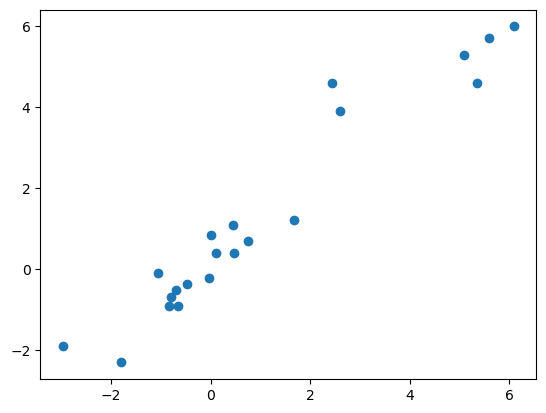

In [343]:
plt.scatter(theta, theta_true)

In [344]:
theta

Array([ 5.5918407 ,  5.365273  ,  6.0937057 ,  2.5987868 ,  2.4502125 ,
        5.0909886 ,  0.11774421,  0.7605806 ,  0.4585721 ,  0.4671227 ,
        0.01441878,  1.6734987 , -1.7924808 , -2.9727042 , -0.66144913,
       -1.0501269 , -0.7934009 , -0.02279904, -0.8310183 , -0.46711153,
       -0.7004548 ], dtype=float32)

In [341]:
theta_true

Array([ 5.7037826 ,  4.6051702 ,  5.9914646 ,  3.912023  ,  4.6051702 ,
        5.2983174 ,  0.4054651 ,  0.6931472 ,  1.0986123 ,  0.4054651 ,
        0.8329091 ,  1.2237755 , -2.3025851 , -1.89712   , -0.9162907 ,
       -0.10536055, -0.6931472 , -0.22314353, -0.9162907 , -0.35667497,
       -0.5108256 ], dtype=float32)

In [340]:
jnp.abs(theta - theta_true) / jnp.abs(theta_true)

Array([0.01962589, 0.16505422, 0.01706445, 0.33569235, 0.46794313,
       0.03913106, 0.70960706, 0.09728586, 0.5825897 , 0.15206638,
       0.98268867, 0.36748835, 0.22153547, 0.56695634, 0.27812305,
       8.966984  , 0.14463551, 0.89782786, 0.09306257, 0.309628  ,
       0.37122104], dtype=float32)

In [359]:
%%time
# run it spatial
pred_out = wbm_jax_vmap(
    tas_in,
    prcp_in, 
    Ws_init_in,
    Wi_init_in,
    Sp_init_in,
    clayfrac_in,
    sandfrac_in,
    siltfrac_in,
    lai_in,
    phi_in,
    doy_in,
    theta,
)

CPU times: user 10.6 s, sys: 1.1 s, total: 11.7 s
Wall time: 11.8 s


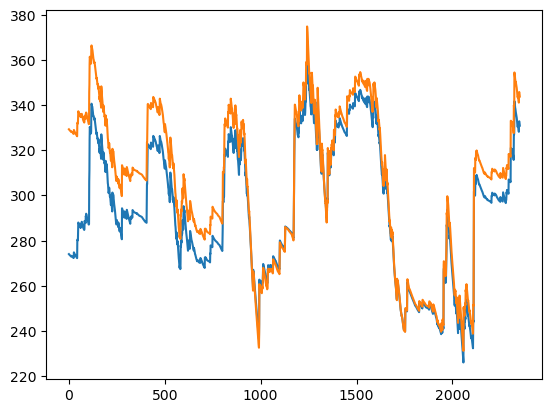

In [364]:
plt.plot(pred_out[2000,:])
plt.plot(ys[2000,:])

In [80]:
def loss_fn(theta, x, y):
    # Must be correct order!
    tas, prcp, Ws_init, Wi_init, Sp_init, clayfrac, sandfrac, siltfrac, lai, phi, doy = x

    # Make prediction
    prediction = wbm_jax_vmap(
        tas,
        prcp, 
        Ws_init,
        Wi_init,
        Sp_init,
        clayfrac,
        sandfrac,
        siltfrac,
        lai,
        phi,
        doy,
        theta
    )
    # Return RMSE 
    return jnp.nanmean(jnp.nanmean((prediction-y)**2, axis=1)) #+ jnp.dot(theta, theta)

In [81]:
@jax.jit
def update(theta, x, y, lr=0.001):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

In [84]:
%%time
theta = jnp.array([awCap_claycoef * 0.9, awCap_sandcoef * 0.9, awCap_siltcoef * 0.9, \
                  wiltingp_claycoef * 0.9, wiltingp_sandcoef * 0.9, wiltingp_siltcoef * 0.9, \
                  alpha_claycoef * 0.9, alpha_sandcoef * 0.9, alpha_siltcoef * 0.9, \
                  betaHBV_claycoef * 0.9, betaHBV_sandcoef * 0.9, betaHBV_siltcoef * 0.9, \
                  Kmin_claycoef * 0.9, Kmin_sandcoef * 0.9, Kmin_siltcoef * 0.9, \
                  Kmax_claycoef * 0.9, Kmax_sandcoef * 0.9, Kmax_siltcoef * 0.9, \
                  Klai_claycoef * 0.9, Klai_sandcoef * 0.9, Klai_siltcoef * 1.1])

x = tas_in, prcp_in,  Ws_init_in, Wi_init_in, Sp_init_in, clayfrac_in, sandfrac_in, siltfrac_in, lai_in, phi_in, doy_in

# n_iter = 2
# for i in range(n_iter):
#     theta = update(theta, x, ys)

CPU times: user 1.99 ms, sys: 4.95 ms, total: 6.94 ms
Wall time: 7.04 ms


In [86]:
jax.grad(loss_fn)(theta, x, ys)

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

In [83]:
theta

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

In [6]:
def loss_fn(theta, init, const, x, y):
    prediction = run_wbm_jax(initial_conditions=init, forcing_data=x, parameters=theta, constants=const)
    return jnp.mean((prediction-y)**2) #+ jnp.dot(theta, theta)

In [55]:
@jax.jit
def update(theta, init, const, x, y, lr=0.00001):
  return theta - lr * jax.grad(loss_fn)(theta, init, const, x, y)

In [70]:
%%time
# theta = jnp.array([-1, 1, 401, 200, 5., 2., 0.2, 1.2, 0.7])
theta = jnp.array([jnp.log(420), jnp.log(200.), jnp.log(5.), jnp.log(2.), jnp.log(0.2), jnp.log(1.2), jnp.log(0.7)])

init = jnp.array([Ws_init, Wi_init, Sp_init])
x = jnp.array([tas, prcp])
const = [rootDepth, lai, phi, doy]

n_iter = 5000
loss = np.empty(n_iter)
for i in range(n_iter):
    theta = update(theta, init, const, x, ys)
    loss[i] = jnp.mean((run_wbm_jax(initial_conditions=init, forcing_data=x, parameters=theta, constants=const) - ys)**2)

CPU times: user 9.25 s, sys: 1.99 ms, total: 9.25 s
Wall time: 9.47 s


In [71]:
jnp.exp(theta)

Array([3.8909045e+02, 2.3305988e+02, 3.2794383e+00, 2.2154231e+00,
       2.6008683e-01, 1.5897355e+00, 3.2680979e-01], dtype=float32)

In [72]:
jax.grad(loss_fn)(theta, init, const, x, ys)

Array([22143.176 , 22061.209 , -2043.7476,  6651.991 , -3455.7695,
       -9326.011 , -5525.794 ], dtype=float32)

In [73]:
# n_iter = 10000
# loss = np.empty(n_iter)
# for i in range(n_iter):
#     theta = update(theta, init, const, x, ys)
#     loss[i] = jnp.mean((run_wbm_jax(initial_conditions=init, forcing_data=x, parameters=theta, constants=const) - ys)**2)

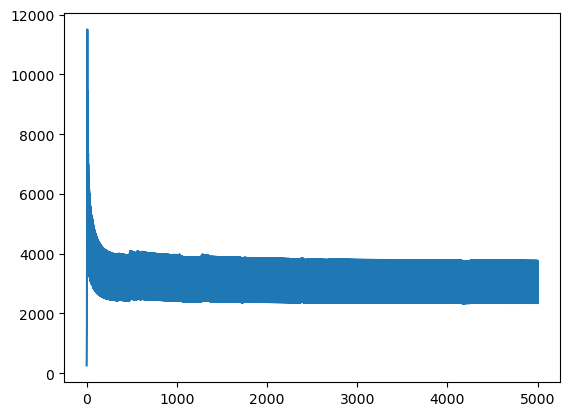

In [74]:
plt.plot(loss)

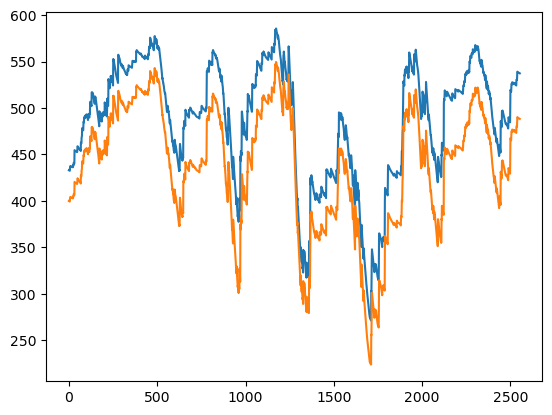

In [75]:
fig, ax = plt.subplots()

ax.plot(run_wbm_jax(initial_conditions=init, forcing_data=x, parameters=theta, constants=const))
ax.plot(ys)

plt.show()

In [12]:
# %%time
# # non-JAX
# # Make dicts
# initial_conditions = {}
# initial_conditions["Ws_init"] = Ws_init
# initial_conditions["Wi_init"] = Wi_init
# initial_conditions["Sp_init"] = Sp_init

# forcing_data = {}
# forcing_data["prcp"] = prcp
# forcing_data["tas"] = tas

# parameters = {}
# parameters["Ts"] = Ts
# parameters["Tm"] = Tm
# parameters['Clai'] = Clai
# parameters["awCap"] = awCap
# parameters["wiltingp"] = wiltingp
# parameters["alpha"] = alpha
# parameters["betaHBV"] = betaHBV
# parameters["Kmin"] = Kmin
# parameters["Kmax"] = Kmax
# parameters["Klai"] = Klai

# constants = {}
# constants["rootDepth"] = rootDepth
# constants["phi"] = phi
# constants['lai'] = np.repeat(test_in['lai'][ix,iy,1:], 7)
# constants["nt"] = len(test_in['tas'][ix,iy,:-2]) - 1
# constants["doy"] = np.arange(1, len(test_in['tas'][ix,iy,:-2]) + 1)

# # run
# out = run_wbm(
#     initial_conditions=initial_conditions,
#     forcing_data=forcing_data,
#     parameters=[parameters[key] for key in parameters.keys()],
#     constants=constants,
# )

# plt.plot(out)
# plt.plot(ys)

In [304]:
def loss_fn(theta, tas, prcp, y):
  prediction = run_gr4j(theta, tas, prcp)
  return jnp.mean((prediction-y)**2)

In [344]:
@jax.jit
def update(theta, tas, prcp, y, lr=0.00001):
  return theta - lr * jax.grad(loss_fn)(theta, tas, prcp, y)

In [365]:
%%time
# theta = jnp.array([0.5, 11., 2.])

for _ in range(50000):
    theta = update(theta, T, P, ys)

CPU times: user 831 ms, sys: 9.33 ms, total: 841 ms
Wall time: 845 ms


In [367]:
theta = update(theta, T, P, ys)

In [368]:
theta

Array([ 0.5957835, 11.538452 ,  1.3691818], dtype=float32)

In [369]:
theta = update(theta, T, P, ys)

In [370]:
theta

Array([ 0.60198766, 11.542145  ,  1.3493962 ], dtype=float32)

In [371]:
theta = update(theta, T, P, ys)

In [372]:
theta

Array([ 0.59578335, 11.538452  ,  1.369182  ], dtype=float32)

b1: 0.60, b2: 11.54, b3: 1.35


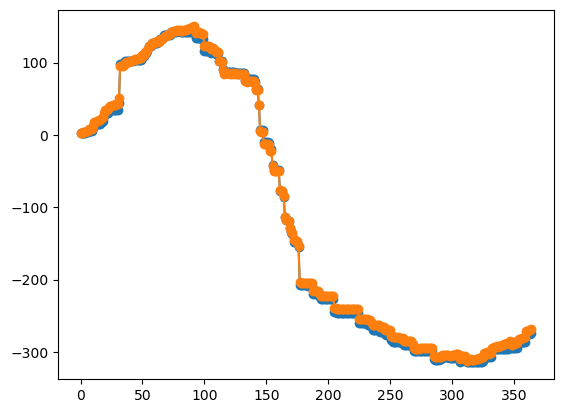

In [366]:
plt.plot(ys, 'o-')
plt.plot(run_gr4j(theta, T, P), 'o-')

b1, b2, b3 = theta
print(f"b1: {b1:<.2f}, b2: {b2:<.2f}, b3: {b3:<.2f}")

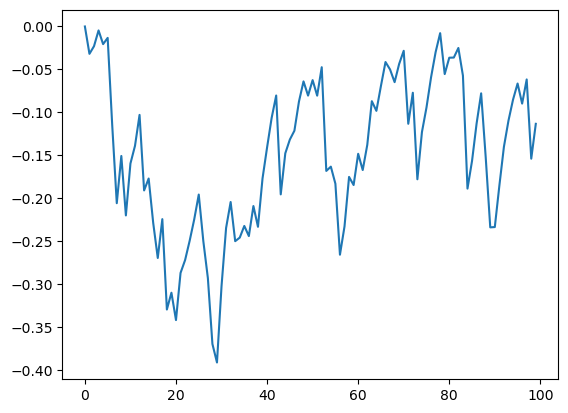

In [208]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(scale=0.1, size=(100,))
xs1 = np.random.normal(scale=0.1, size=(100,))
noise = np.random.normal(scale=0.01, size=(100,))
ys = np.zeros(100)
for t in range(1,len(ys)):
    c = np.zeros(100)
    if xs1[t] > 0.05:
        c[t] = c[t-1] + 1.
    if xs[t] > 0.:
        ys[t] = xs[t]*0.1 + ys[t-1]*0.8 - 0.1*c[t]
    elif xs[t] <= 0.:
        ys[t] = xs[t]*0.3 + ys[t-1]*0.8 - 0.1*c[t]
    
plt.plot(ys);

In [239]:
from numba import njit

### WBM

In [4]:
######################
# Select state
name = 'illinois'
######################

T = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_temperature.txt")
P = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_precip.txt")
lai = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_lai.txt")
soilMoist = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_soilMoist.txt")[0]
soilMoistFrac = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_soilMoistFrac.txt")
Kc = np.loadtxt(f"/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_toy_model/data/{name}_kc.txt")

# Select correct latitiude
# SD: [44,-98]
# IA: [42,-93]
# IL: [40,-89]
lat_dict = {"southdakota":44., "iowa":42., "illinois":40.}
lat = lat_dict[name]

################
# Inputs
################
phi = lat          # Latitude
Ws_init = soilMoist  # Initial soil moisture: take from WBM
Wi_init = 0.5           # Canopy water storage
Sp_init = 0.             # Snowpack

# Make dicts
initial_conditions = {}
initial_conditions["Ws_init"] = Ws_init
initial_conditions["Wi_init"] = Wi_init
initial_conditions["Sp_init"] = Sp_init

forcing_data = {}
forcing_data["prcp"] = P
forcing_data["tas"] = T

X = np.loadtxt('/Users/davidlafferty/Projects/UIUC/WBM_UC/wbm_soilM_crop_uc_lafferty-etal-2024-tbd/code/param_values.txt', float)
iparam = 1000
parameters = {}
parameters["Ts"] = X[iparam][0]
parameters["Tm"] = X[iparam][1]
parameters['Clai'] = X[iparam][2]
parameters["awCap"] = X[iparam][3]
parameters["wiltingp"] = X[iparam][4]
parameters["alpha"] = X[iparam][5]
parameters["betaHBV"] = X[iparam][6]
parameters["Kmin"] = X[iparam][7]
parameters["Kmax"] = X[iparam][8]
parameters["Klai"] = X[iparam][9]

constants = {}
constants["lai"] = lai
constants["phi"] = phi
constants["nt"] = len(T)-1
constants["doy"] = np.arange(1,len(T)+1)
constants["rootDepth"] = 1000.

# run
out = wbm(
    initial_conditions=initial_conditions,
    forcing_data=forcing_data,
    parameters=[parameters[key] for key in parameters.keys()],
    constants=constants,
)

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [ ]:
plt.plot(out)

In [5]:
def loss_fn(params, y):
  prediction = wbm(
      initial_conditions=initial_conditions,
      forcing_data=forcing_data,
      parameters=params,
      constants=constants,
  )

    
  return jnp.mean((prediction-y)**2)

In [ ]:
params = jnp.array([parameters[key] for key in parameters.keys()])

In [ ]:
jax.grad(loss_fn)(params, out)

In [123]:
@jax.jit
def update(params, Ws_out, lr=0.0001):
  return params - lr * jax.grad(loss_fn)(params, Ws_out)

In [124]:
params = jnp.array([100., 100., 1., 1.])

In [125]:
jax.grad(loss_fn)(params, Ws_out)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float32[1,1].
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [53]:
params = jnp.array([100., 100., 1., 1.])

for _ in range(1000):
  params = update(params, Ws_out)

IndexError: Too many indices for array: 2 non-None/Ellipsis indices for dim 0.